In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
path = 'bike_buyers.csv'
compradores = pd.read_csv(path)
compradores.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


# Limpieza de los datos

Vamos a limpiar nuestro dataset para seleccionar nuestras variables independientes X y nuestra variable dependiente y, además de procesar los datos para transformar valores categóricos a su representación númerica

Revisaremos primero si podemos sustituir valores nulos de algunas columnas para no remover filas de nuestro dataset

In [3]:
compradores.isna().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [4]:
compradores.dropna(subset = ['Income','Children','Home Owner', 'Cars','Age','Marital Status','Gender'], axis = 0, inplace = True)
compradores.isna().sum()

ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
Purchased Bike      0
dtype: int64

In [5]:
compradores.reset_index(drop = True, inplace = True)

# Transformación de los datos

Vamos a obtener la representación númerica de las variables categóricas del conjunto de datos

In [6]:
from sklearn.preprocessing import OrdinalEncoder
comp = compradores[['Marital Status','Gender','Education','Occupation','Home Owner','Region','Commute Distance','Purchased Bike']]
ordinal = OrdinalEncoder()
X = ordinal.fit_transform(comp)
df = pd.DataFrame(X,columns=['Marital Status','Gender','Education','Occupation','Home Owner','Region','Commute Distance','Purchased Bike'])
num = compradores[['Income','Children','Cars','Age']]
buyers_tree = pd.concat([df, num], axis=1)
buyers_x = buyers_tree[['Marital Status','Gender','Education','Occupation','Home Owner','Region','Commute Distance','Income','Children','Cars','Age']]
buyers_y = buyers_tree['Purchased Bike']
buyers_tree.head()

,Marital Status,Gender,Education,Occupation,Home Owner,Region,Commute Distance,Purchased Bike,Income,Children,Cars,Age
0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,40000.0,1.0,0.0,42.0
1,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,30000.0,3.0,1.0,43.0
2,0.0,1.0,3.0,3.0,0.0,0.0,3.0,0.0,80000.0,5.0,2.0,60.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,30000.0,0.0,0.0,36.0
4,0.0,0.0,3.0,2.0,1.0,0.0,1.0,0.0,10000.0,2.0,0.0,50.0


## Entrenamiento/Pruebas del modelo

Dividiremos los datos en un 80% para entrenamiento y el 20% restante para probar el modelo

In [7]:
buyers_x = np.asarray(buyers_x)
buyers_y = np.asarray(buyers_y.astype('int'))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(buyers_x, buyers_y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (761, 11) (761,)
Test set: (191, 11) (191,)


# Modelos de clasificación

## Random Forest

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}


Ahora vamos a predecir usando nuestros datos de pruebas

In [10]:
yhat_rf = CV_rfc.predict(X_test)

## SVM

In [24]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn import svm

In [25]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_rescaled = scaling.transform(X_train)

In [26]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly']} 
  
CV_svm = GridSearchCV(svm.SVC(), param_grid_svm, refit = True)
  
# fitting the model for grid search
CV_svm.fit(X_train_rescaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.588 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.566 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.625 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.724 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.711 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.641 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.579 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.638 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.717 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.711 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.588 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear

[CV 1/5] END ........C=10, gamma=1, kernel=poly;, score=0.660 total time=   2.0s
[CV 2/5] END ........C=10, gamma=1, kernel=poly;, score=0.520 total time=   1.3s
[CV 3/5] END ........C=10, gamma=1, kernel=poly;, score=0.599 total time=   2.3s
[CV 4/5] END ........C=10, gamma=1, kernel=poly;, score=0.645 total time=   2.3s
[CV 5/5] END ........C=10, gamma=1, kernel=poly;, score=0.697 total time=   2.2s
[CV 1/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.588 total time=   0.0s
[CV 2/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.559 total time=   0.0s
[CV 3/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.625 total time=   0.0s
[CV 4/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.724 total time=   0.0s
[CV 5/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.697 total time=   0.0s
[CV 1/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.667 total time=   0.0s
[CV 2/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.599 total time=   0.0s
[CV 3/5] END ......C=10, gam

[CV 3/5] END ......C=1000, gamma=1, kernel=poly;, score=0.625 total time=   8.6s
[CV 4/5] END ......C=1000, gamma=1, kernel=poly;, score=0.632 total time=  28.8s
[CV 5/5] END ......C=1000, gamma=1, kernel=poly;, score=0.658 total time= 1.4min
[CV 1/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.595 total time=   1.4s
[CV 2/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.559 total time=   2.9s
[CV 3/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.625 total time=   2.1s
[CV 4/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.724 total time=   2.1s
[CV 5/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.697 total time=   2.9s
[CV 1/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.680 total time=   0.2s
[CV 2/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.579 total time=   0.2s
[CV 3/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.618 total time=   0.2s
[CV 4/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.599 total time=   0.2s
[CV 5/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly']},
             verbose=3)

In [27]:
yhat_svm = CV_svm.predict(scaling.transform(X_test))

## Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB

In [20]:
NB = ComplementNB()
NB.fit(X_train, y_train)

ComplementNB()

In [21]:
yhat_nb = NB.predict(X_test)

# Evaluación

## Resultados Ranfom Forest

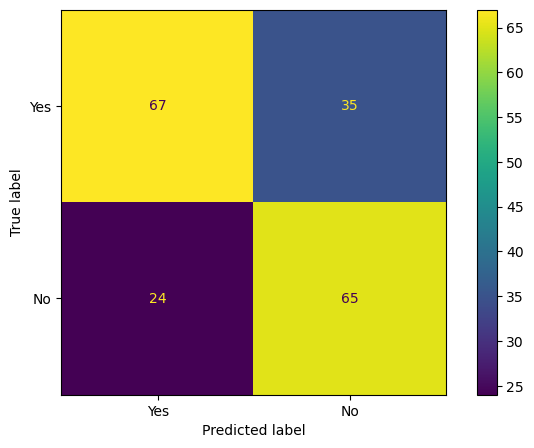

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, yhat_rf),
    display_labels=["Yes", "No"],
)

cmp.plot(ax=ax);

In [14]:
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       0.74      0.66      0.69       102
           1       0.65      0.73      0.69        89

    accuracy                           0.69       191
   macro avg       0.69      0.69      0.69       191
weighted avg       0.70      0.69      0.69       191



## Resultados SVM

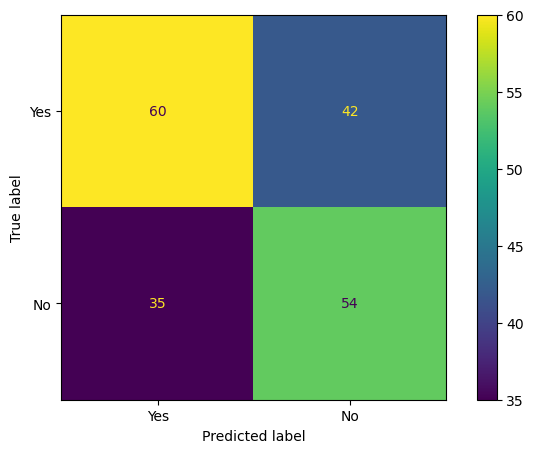

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, yhat_svm),
    display_labels=["Yes", "No"],
)

cmp.plot(ax=ax);

In [30]:
print(classification_report(y_test, yhat_svm))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       102
           1       0.56      0.61      0.58        89

    accuracy                           0.60       191
   macro avg       0.60      0.60      0.60       191
weighted avg       0.60      0.60      0.60       191



## Resultados NB

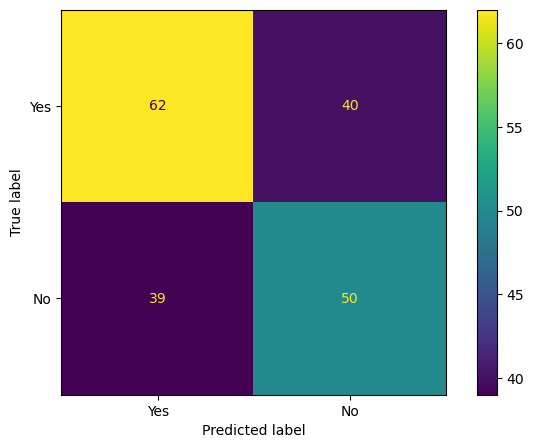

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, yhat_nb),
    display_labels=["Yes", "No"],
)

cmp.plot(ax=ax);

In [23]:
print(classification_report(y_test, yhat_nb))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       102
           1       0.56      0.56      0.56        89

    accuracy                           0.59       191
   macro avg       0.58      0.58      0.58       191
weighted avg       0.59      0.59      0.59       191

